In [25]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET 
from PIL import Image 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout,Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.backend import random_normal, ones_like, zeros_like,mean
from tensorflow.keras.layers import UpSampling2D, Conv2D, concatenate
from tensorflow.keras.layers import LeakyReLU
from keras.callbacks import LearningRateScheduler
from time import time

# Kaggle Competition: Generation of Dog Images with GAN

## Introduction

The goal of a GAN is to "learn" the probability density function of a particular data distribution. The data distribution should be specific and diverse; for instance "trees" is an excellent choice, because they are distinct from other plants, and there are many subcategories for breadth of distribution. That is to say, the distribution is wide, not narrow. The data we use today comes from a [Kaggle competition](https://www.kaggle.com/competitions/generative-dog-images/overview), and contains many photos of different breeds of dogs. In this project, I will follow along with a few successful notebooks from that competition (now over) to give myself an introduction to the construction of GAN's. I'll try to properly cite everything I'm doing - if I miss something please let me know. 

In [2]:
# Citation https://stackoverflow.com/questions/3451111/unzipping-files-in-python
import zipfile

with zipfile.ZipFile("../input/generative-dog-images/all-dogs.zip","r") as zip_ref:
    zip_ref.extractall("./data/")
    
with zipfile.ZipFile("../input/generative-dog-images/Annotation.zip","r") as zip_ref:
    zip_ref.extractall("./data/")

In [3]:
# Citation https://www.kaggle.com/code/paulorzp/show-annotations-and-breeds/notebook

dogPics = os.listdir("./data/all-dogs/")
breeds = os.listdir("./data/Annotation/")

indexIn = 0
namesIn = list()
#imagesIn will be the new container for cropped images
imagesIn = np.zeros((25000, 64, 64, 3))

for breed in breeds:
    for dog in os.listdir("./data/Annotation/" + breed):
        try:
            this_dog = Image.open("./data/all-dogs/" + dog + ".jpg" )
        except:
            continue
        tree = ET.parse("./data/Annotation/" + breed + "/" + dog)
        root = tree.getroot()
        objects = root.findall("object")
        for this_ob in objects:
            bndbox = this_ob.find('bndbox') 
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            w = np.min((xmax - xmin, ymax - ymin))
            img2 = this_dog.crop((xmin, ymin, xmin+w, ymin+w))
            img2 = img2.resize((64,64), Image.ANTIALIAS)
            imagesIn[indexIn,:,:,:] = np.asarray(img2)
            if indexIn % 1000==0:  #Optional Loading bar
                print(indexIn)
            namesIn.append(breed)
            indexIn += 1

In [5]:
# Shuffle dog pics so discriminator doesn't learn to associate dog breeds with index
index = np.arange(indexIn)
np.random.shuffle(index)
imagesIn = imagesIn[index,:,:,:]
namesIn = np.array(namesIn)[index]

In [6]:
# Display some cropped images

x = np.random.randint(0, indexIn, 25)
for k in range(3):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray(imagesIn[x[k*5+j],:,:,:].astype('uint8') )
        plt.axis('off')
        plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show()


## Exploratory Data Analysis

The following EDA was performed by examining the "properties" page of my directories manually. The data supplied by the Kaggle contain 775.22 MB constisting of 20,582 zipped dog images, with 17.62 MB of zipped breed labels. There is exactly one label for one dog image. There were a total of 120 distinct breeds in the data. After unzipping, my all-dogs folder within ./data/ contained 781 MB on disk, and the labels took up 5.3 MB on disk. After cleaning:

In [7]:
from sys import getsizeof
print("The cropped dog images have combined data usage of:", round(getsizeof(imagesIn)/(1e9), 2), "GB")
print("The breed names of cropped dog images have combined data usage of:", round(getsizeof(namesIn)/(1e6), 2), "MB")

While our assignment instructions dictate that we use a histogram or other plots to visualize the data, such tools are inappropriate in this context. The GAN discriminator will be comparing the "noise" images made by the GAN generator. Here is a nice visualization supplied by Kaggle user [Ashish Gupta](https://www.kaggle.com/code/roydatascience/introduction-to-generative-adversarial-networks):

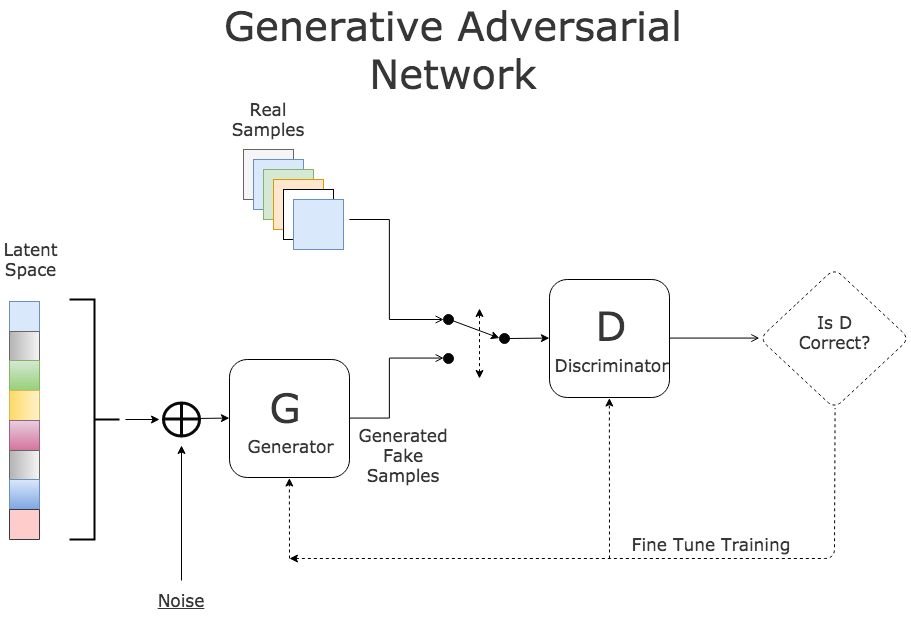


## Model Construction

A GAN really consists of two different bots. A discriminator is a supervised nueral network that is trained on random alterations of real data, whose job is to determine whether a supplied datum is "real" or "fake". Our discriminator will be fed images of dogs *with intentionally noised up pixels* so that it does not simply memorize the ~20,000 images of dogs. A generator will be a nueral network that generates fake samples to feed into the discriminator. Initially the generator will have random weights, resulting in random Normal noise images. They will look like static, and nothing like dogs. As the discriminator learns to determine static from dogs, so will the generator learn to "fool" the discriminator into accepting fake images. There is some super interesting evolutionary game theory that goes into this, I would highly recommend reading material on this! Eventually, we will reach an equilibrium where the discriminator and generator reach a Nash Equilibrium, and the entire system cannot get better at generating new data without additional input images / data. 

First, I will build a discriminator.

In [8]:
# Set initial variables
num_pixels = 12288
in1 = Input((num_pixels, ))
noise_size = 10000
in2= Input((noise_size, ))
batch_size = 64
buffer = 10000

In [9]:
# Build discriminator,
## Citation https://www.kaggle.com/code/roydatascience/introduction-to-generative-adversarial-networks
## Citation cdeotte

x = Dense(num_pixels, activation = "sigmoid")(in2)
conc = concatenate([in1, x])
x = Reshape((2, num_pixels, 1))(conc)
x = Conv2D(filters = 1,
            kernel_size = [2, 1],
            use_bias = False,
            name = 'conv')(x)
x = Flatten()(x)

In [10]:
model = x
model_discrim = Model([in1, in2], model)

#We don't want the discriminator to change it's weights for the
## real images, so we will prevent them from training
model_discrim.get_layer("conv").trainable = False

#We want to set the initial weights for the discriminator
initial_discrim_weights = np.array([[[[-1.0 ]]],[[[1.0]]]])
model_discrim.get_layer("conv").set_weights([initial_discrim_weights])

#Look at a model summary for the discriminator
print("Here's the model summary for our discriminator:")
model_discrim.summary()

### Commentary

That's a really big model! There are over 120 million trainable parameters, so we expect the model to run for a very long time before converging. That doesn't even include competition against the generator, which hasn't been construted yet. Before building the generator we first need to train the discriminator on the real dog photos. Let's do that. I did a grid search as hyper-parameter optimization over the learning rate eta. My best result was eta = 0.5. I'll leave in the grid search commented out, but due to resource intensity I don't want to use too much GPU RAM. 

In [11]:
#Compile disciminator. We use loss as binary crossentropy because we want to classify input images as either "real" or "fake".
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate = 0.5,
      decay_steps = 10000,
      decay_rate=0.9
      )

model_discrim.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule),
                     loss = "binary_crossentropy"
                     )

#Train the discriminator on the first 10,000 dogs
n_samples = 10000
train_noise = np.zeros((n_samples, n_samples))
for i in range(n_samples):
    train_noise[i, i] = 1
zeros = np.zeros((n_samples, num_pixels))
    
#We map the RGB pixel values to [0,1] for stability, and flatten to feed into the discriminator
train_imgs = (imagesIn[:n_samples,:,:,:]/255.).reshape((-1, num_pixels)) 

callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor = "loss", patience = 10, mode = "min")]

#startTime = time()
#current_best = (None, 0)
#for k in range(5): #Citation roydatascience
#    this_history = model_discrim.fit([zeros, train_noise],
#                                    train_imgs,
#                                    epochs = 100,
#                                    batch_size = batch_size,
#                                    validation_split = 0.1,
#                                    callbacks = callbacks_list,
#                                    verbose = 0
#                                    )
#    print('Epoch',(k+1)*10,'/50 - loss =',h.history['loss'][-1] )
#    if this_history.history['loss'][-1]<0.533: lr = 0.1

#endTime = time()
#print("Total grid search time:", round(endTime - startTime, 2), "seconds")

discrim_history = model_discrim.fit([zeros, train_noise],
                                    train_imgs,
                                    epochs = 100,
                                    batch_size = batch_size,
                                    callbacks = callbacks_list,
                                    verbose = 0
                                   )

### Commentary

Let's visualize the training for the discriminator. We'll graph loss vs. epoch.



In [12]:
loss = discrim_history.history["loss"]
epochs = [i for i in range(len(loss))]

plt.plot(epochs, loss)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Loss Vs. Epoch for Discriminator")
plt.show()


Now that we have the discriminator trained, let's go ahead and delete all the training data to conserve RAM, because I'm almost out on kaggle. We will freeze the training weights

In [32]:
del train_noise, train_imgs, imagesIn

### Commentary:

We have built a memorizer Discriminator. The discriminator "knows" within its weights what a dog looks like. Now all that's left is to build a generator, and to make the discriminator fight it.

Let's build a generator. In order to prevent the generator from just learning to feed pixel values that the discriminator expects to see, we will throttle the latent space of the generator. This will force the generator to learn the distribution the discriminator expects rather that specific digits. That is, it will only be able to "remember" a finite amount of information - instead of memorizing pixels, it will memorize a function to generate from.

In [36]:
# Citation cdeotte
#We will use UpSampling2D to utilize the algorithm shown in class for image data
seed = Input((n_samples,)) 
x = Dense(2048, activation='elu')(seed)
x = Reshape((8,8,32))(x)
x = Conv2D(128, (3, 3), activation='elu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='elu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='elu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), activation='linear', padding='same')(x)
generated = Flatten()(x)

# Reshape output to feed into discriminator
reshaped = Reshape((n_samples,))(seed)

# Compile generator
model_gen = Model(seed, [generated, reshaped])
print("Here's the summary for the generator:")
model_gen.summary()

### Commentary:

Another very big model! This is going to take quite some time to train. In the future, I think a wise move would be resize the images to 32 X 32 instead of 64 X 64 to help save on space. Lets connect the generator and discriminator to build ourselves a GAN.

In [37]:
#Citation cdeotte
model_discrim.trainable = False
GAN_in = Input(shape = (n_samples, ))
x = model_gen(GAN_in)
GAN_out = model_discrim(x)

#Compile GAN
GAN = Model(GAN_in, GAN_out)
initial_GAN_weights = np.array([[[[-1 ]]],[[[255.]]]])
GAN.get_layer("model").get_layer("conv").set_weights([initial_GAN_weights])

GAN.compile(optimizer = "Adam",
           loss = "mean_squared_error"
           )

GAN.summary()

In [39]:
# Citation cdeotte
# TRAINING DATA
train_noise = np.zeros((n_samples, n_samples))
for i in range(n_samples): train_noise[i,i] = 1
zeros = np.zeros((n_samples, num_pixels))

# TRAIN NETWORKS
epochs = 1
it = 15
lr = 0.005
    
for k in range(it):  
    startTime = time()
    annealer = LearningRateScheduler(lambda x: lr)
    h = GAN.fit(train_noise,
                zeros,
                epochs = epochs,
                batch_size = 256,
                callbacks=[annealer],
                verbose=0
               )
    
    print('Epoch',(k+1),'/'+str(it)+' - loss =',h.history['loss'][-1] )
    
    plt.figure(figsize=(15,3))
    
    # Show the current generator's ability to make dogs out of noise
    for j in range(5):
        xx = np.zeros((10000))
        xx[np.random.randint(10000)] = 1
        plt.subplot(1,5,j+1)
        img = model_gen.predict(xx.reshape((-1,10000)))[0].reshape((-1,64,64,3))
        img = Image.fromarray( (img).astype('uint8').reshape((64,64,3)))
        plt.axis('off')
        plt.imshow(img)
        
    plt.show()  
    
    # Adjust eta
    epochs *= 2
    if epochs >= 32:
        lr = 0.001
    if epochs > 256:
        epochs = 256
    endTime = time()
    print("Total epoch training time:", round(endTime - startTime, 2)/60, "minutes")

## Results and Analysis

We have successfully trained our generator to make dog images! I ended up running 12 iterations consisting of a varying number of epochs. That's why there's a big red error message that says "Keyboard Interrupt". As the number of epochs changed, so did the learning rate to help prevent overfitting. I really can't overstate how wonderful a resource user cdeotte's dog-memorizer-gan notebook was, this project would have been impossible without it. Really all I did was work through his and others tutorials in how to create a GAN in tensorflow and add comments and customization. 

It's important to note that the generator *did not know* about the different dog breeds, but the discriminator did. As such the generator learned the common features shared by all breeds, as well as the unique features that pertain only to individual breeds. It's really fascinating to watch the generator's understanding of the true "dog" pdf evolve. The final model is still imperfect, as can be seen in the pixellation and fuzziness in the output images. What I think is most fascinating about the GAN is it's ability to not only model what you expect it to. The GAN also predicts common backgrounds for dogs! In epoch 11, there is a very convincing image of what appears to be a German Shepherd standing near a street by a park. That's not a German Shepherd, that's not a street, and that's not a park. They are a random collection of pixels that an AI learned would trick another AI into believing the image was "real" with respect to a metric (MSE). 

One important note: it is possible to overfit the data, because we are just trying to make a generator that passes an MSE checker. As the training time increases, the MSE will asymptotically converge to the "real" loss of 0, which would indicate we are just replicating the images stored in our Memorizer Discriminator. This is not an issue in a traditional GAN, because the discriminator doesn't "know" a priori what a "dog" is - it learns in competition with the generator.

I'd like to include some visualizations. I think the intermittant outputted dog photos are sufficient to understand what the generator is doing during the GAN training. Let's make a nice visualization regarding MSE and epoch, then submit some fake dogs to kaggle and get a score.

In [41]:
MSEs = [6605, 2476, 1271, 703, 454, 311, 219, 150, 108, 92, 83, 78]
epochs = [i + 1 for i in range(len(MSEs))]

plt.plot(epochs, MSEs)
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("GAN MSE Vs. Epoch")
plt.show()

In [42]:
#Fake dog image maker
def makeDog(seed, index):
    # Function makes an 80/20 split between two types of dogs
    doggy_zeros = np.zeros((n_samples))
    doggy_zeros[index] = 0.80
    random_sample = np.random.randint(n_samples)
    doggy_zeros[random_sample] = 0.30
    this_pic = model_gen.predict(doggy_zeros.reshape((-1, n_samples)))[0]
    this_pic = this_pic.reshape((64,64,3))
    new_index = (index + 1) % 10000 # Citation cdeotte
    dog_pic = Image.fromarray(this_pic.astype("uint8"))
    
    return (dog_pic, new_index)

In [43]:
# Make some fake dogs to send to Kaggle
zippy = zipfile.PyZipFile("images.zip", mode = "w")

idx = 0
for j in range(n_samples):
    #Generate a random dog
    this_seed = np.random.normal(0, 1, 100)
    (this_dog, idx) = makeDog(seed = this_seed, index = idx)
    
    #Save the dog to a temporary file
    fileName = str(j) + ".png"
    this_dog.save(fileName, "PNG")
    
    #Zip the file then delete the temp
    zippy.write(fileName)
    os.remove(fileName)
    
    #Print progress
    if j % 1000 == 0:
        print(j)

zippy.close()

In [47]:
os.listdir(".")

## Conclusion

In this project I walked through a finished Kaggle competition to learn how to create, train, and make predictions with a memorizer GAN. The general process was as follows:

1) Import and clean data.

2) Do an EDA to understand the data.

3) Create a discriminator model to tell photos of dogs apart from random noise. The discriminator memorized 10,000 dogs, and so our GAN is a memorizer GAN and not a general GAN.

4) Create a generator model that can do reverse convolution to transform noise into sensible images of dogs.

5) Connect the genererator to the discriminator through a throttle so that the generator cannot simply mimic each individual pixel expected by the discriminator.

6) Train that GAN. I ended up using slightly over 12 epochs before I got tired of waiting for marginal improvement. By 12 epochs the generator had made many very convincing dog images still with notable imperfections.

7) Submit to Kaggle for a score.

I learned a lot, largely thanks to user cdeotte. Many, many of the publicly available notebooks that I looked at to learn how to make a GAN reference / emulate his work. My project is no different. Thanks for the knowledge cdeotte, you have significantly contributed to my education.

In the future I would like to build a general GAN, but for this project I was worried about making the shapes work. In addition general GAN's are much more computationally expensive, and Kaggle barely supplied me with enough CPU and GPU RAM to run this project. If I can find a couple nice auxillary graphics cards to program on, making a general GAN is a top priority.